Populating the interactive namespace from numpy and matplotlib
[('NN', 994876), ('IN', 379166), ('JJ', 302062), ('NNS', 293766), ('DT', 283586)]


`%matplotlib` prevents importing * from pylab and numpy


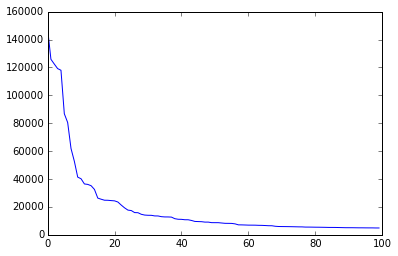

,             125824
.             122420
****           32532
:              25504
experience     24920
work           18209
role           16962
team           16298
client         16251
care           14246
dtype: int64


In [52]:
import nltk
from nltk.corpus import brown
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.stem import WordNetLemmatizer
import operator
import csv
%pylab inline


def preprocessing():
    job_descriptions = pd.read_csv('Train_15000.csv')['FullDescription']
    # Tokenize
    words = [w.lower() for job_description in job_descriptions for w in nltk.word_tokenize(job_description.decode("ascii", "ignore"))]
    return words

def words():
    words = preprocessing()    
    words_tagged = nltk.pos_tag(words)
    tags = [b for (a, b) in words_tagged]

    # Count each part-of-speech
    tag_dict = {}
    for tag in set(tags):
        tag_dict[tag] = 0

    for tag in tags:
        tag_dict[tag] += 1
    sorted_tag = sorted(tag_dict.items(), key=operator.itemgetter(1), reverse = True)
    print sorted_tag[:5]


def zipf():
    text_normal = preprocessing()
    word_freq = pd.Series(text_normal).value_counts()
    plt.plot(word_freq[0:100].values)
    plt.show()

def processed():
    text_normal = preprocessing()

    # remove stopwords
    no_stopword = [word for word in text_normal if word not in stopwords.words('english')]

    # lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in no_stopword]

    word_freq = pd.Series(lemmatized).value_counts()
    return word_freq[0:10]

words()
zipf()
print(processed())

In [50]:
import nltk
from nltk.corpus import brown
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.stem import WordNetLemmatizer
%pylab inline
from sklearn.cross_validation import train_test_split
import numpy.random as npr
from sklearn.feature_extraction.text import TfidfTransformer

### PART B preparation

# drop non-string fields in df, combine each row into one string
def str_text():
    # use pandas read_csv instead of basic form read()!
    text_df = pd.read_csv('Train_15000.csv')
    # drop SalaryNormalized and save it in a new variable
    salary = text_df.pop('SalaryNormalized')
    # drop columns we don't want
    text_df = text_df.drop('Id', axis=1)
    text_df = text_df.drop('SalaryRaw', axis=1)
    # write a function to convert a row into a string
    def to_str(row):
        return ' '.join(pd.Series(row.values).map(str))
    text_str = text_df.apply(to_str, axis=1)
    text_str = pd.Series([text.decode('ascii', 'ignore') for text in text_str])
    return text_str, salary

    

# B1 -- basic multinomial bayes prediction
def prediction():
    text_str = str_text()[0]
    # get the bag of words
    vectorizer = CountVectorizer(min_df=1)
    X = vectorizer.fit_transform(text_str)
    X = X.toarray()

    # mask the salary into high (75 percentile and above) and low (below that)
    salary = str_text()[1]
    cutoff = salary.quantile(q=.75)
    y = (salary >= cutoff)
    
    # resample the high salary to make equal sample of high and low salary
    n = len(y[y==0])
    index_high = [i for i in y.index if y[i]]
    index_low = [i for i in y.index if not y[i]]
    new_high = npr.choice(index_high, size = n, replace = True)
    high_X = X[new_high]
    high_y = y[new_high]
    low_X = X[index_low]
    low_y = y[index_low]
    new_X = np.concatenate((low_X, high_X), axis=0)
    new_y = np.concatenate((low_y, high_y), axis = 0)
    

    # split into training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.4, random_state=42)

    # fit the model and predict
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print('Multinomial prediction:')
    return conf_matrix, accuracy

# B2: bayes with lemmatization, B3: bayes without stopwords
def prediction_lemma():
    text_str = str_text()[0]

    # use lemmatization. My guess is it will improve the result but not much, since 92% is already very good.
    wordnet_lemmatizer = WordNetLemmatizer()

    # first split rows into tokens and lemmatize each of them
    def lemma(row):
        text_token = nltk.word_tokenize(row)
        return [wordnet_lemmatizer.lemmatize(word) for word in text_token]
    lemmatized = text_str.apply(lemma)
    # and then merge tokens back into strings, and then put strings into a series, because fit_transform() only takes series
    lemmatized_str = pd.Series([' '.join(row) for row in lemmatized])

    # construct X sparse matrix as usual
    vectorizer = CountVectorizer(min_df=1)
    X = vectorizer.fit_transform(lemmatized_str)
    X = X.toarray()

    # construct y vector as usual. mask the salary into high (75 percentile and above) and low (below that)
    salary = str_text()[1]
    cutoff = salary.quantile(q=.75)
    y = (salary >= cutoff)

    # resample the high salary to make equal sample of high and low salary
    n = len(y[y==0])
    index_high = [i for i in y.index if y[i]]
    index_low = [i for i in y.index if not y[i]]
    new_high = npr.choice(index_high, size = n, replace = True)
    high_X = X[new_high]
    high_y = y[new_high]
    low_X = X[index_low]
    low_y = y[index_low]
    new_X = np.concatenate((low_X, high_X), axis=0)
    new_y = np.concatenate((low_y, high_y), axis = 0)
    
    # split into training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.4, random_state=42)

    # fit the model and predict
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print('Multinomial prediction with lemmatization:')
    print(conf_matrix, accuracy)

    # continue with removing stopwords. B3.
    def stop(row):
        return [word for word in row if word not in stopwords.words('english')]
    no_stopword = lemmatized.map(stop)
    no_stopword_str = pd.Series([' '.join(row) for row in no_stopword])

    vectorizer = CountVectorizer(min_df=1)
    X = vectorizer.fit_transform(no_stopword_str)
    X = X.toarray()
    
    # resample the high salary to make equal sample of high and low salary
    n = len(y[y==0])
    index_high = [i for i in y.index if y[i]]
    index_low = [i for i in y.index if not y[i]]
    new_high = npr.choice(index_high, size = n, replace = True)
    high_X = X[new_high]
    high_y = y[new_high]
    low_X = X[index_low]
    low_y = y[index_low]
    new_X = np.concatenate((low_X, high_X), axis=0)
    new_y = np.concatenate((low_y, high_y), axis = 0)

    # split into training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.4, random_state=42)

    # fit the model and predict
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    # removing stopwords slightly hurt the result.
    print('Multinomial prediction without stopwords:')
    print(conf_matrix, accuracy)

    # show the top 10 indicative words
    # construct a series with negative class (low salary) features and probabilities, sort it, get the first 10
    no_prob = pd.Series(data=clf.feature_log_prob_[0], index=vectorizer.get_feature_names())
    no_prob.sort(ascending=False)
    print('top 10 indicative words for low salary class:')
    print(no_prob[:10])

    # high salary features
    yes_prob = pd.Series(data=clf.feature_log_prob_[1], index=vectorizer.get_feature_names())
    yes_prob.sort(ascending=False)
    print('top 10 indicative words for high salary class:')
    print(yes_prob[:10])

from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# B4
def bigram():
    text = str_text()

    # this is a function I adapted from http://streamhacker.com/2010/05/24/text-classification-sentiment-analysis-stopwords-collocations/
    # basically it takes in a string of tokenized words (one job description = one string),
    # creates all possible bigrams, and finds the most important bigrams based on a score (feature selection!),
    # and returns a string of all unigrams (= words) and bigrams
    def bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=100):
        bigram_finder = BigramCollocationFinder.from_words(words)
        bigrams = bigram_finder.nbest(score_fn, n)
        # make sure all elements in the list are strings instead of lists, otherwise join() won't take it
        bigrams = [str(b) for b in bigrams]
        words = [str(w) for w in words]
        # merge two lists
        words = words + bigrams
        # return a string of bigrams and unigrams
        return ' '.join(words)

    ### IT'S ALL ABOUT DATA STRUCTURE AND DATA TYPE...
    # WHAT FEEDS INTO THE X IN FINAL MODEL? a series, and each element should contain all unigrams and bigrams
    # so that's what we're gonna do. bigram_word_feats() builds the elements for us, we have to put them into a series now
    all_rows_list = []
    # the data structure of text is: a tuple, length is 2, element 1 is a series of all job descriptions, element 2 is all salaries
    for i in range(len(text[0])):
        row_tokenized = nltk.word_tokenize(text[0][i])
        liststr = bigram_word_feats(row_tokenized)
        all_rows_list.append(liststr)
    all_rows_series = pd.Series(all_rows_list)

    # build the X matrix
    vectorizer = CountVectorizer(min_df=1)
    X = vectorizer.fit_transform(all_rows_series)
    
    
    X = X.toarray()

    # build y by masking the salary into high (75 percentile and above) and low (below that)
    salary = str_text()[1]
    cutoff = salary.quantile(q=.75)
    y = (salary >= cutoff)
    
    n = len(y[y==0])
    index_high = [i for i in y.index if y[i]]
    index_low = [i for i in y.index if not y[i]]
    new_high = npr.choice(index_high, size = n, replace = True)
    high_X = X[new_high]
    high_y = y[new_high]
    low_X = X[index_low]
    low_y = y[index_low]
    new_X = np.concatenate((low_X, high_X), axis=0)
    new_y = np.concatenate((low_y, high_y), axis = 0)

    # split into training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.4, random_state=42)

    # fit the model and predict
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print('Multinomial prediction with bigram:')
    return conf_matrix, accuracy


def tf_idf():
    text = str_text()

    # this is a function I adapted from http://streamhacker.com/2010/05/24/text-classification-sentiment-analysis-stopwords-collocations/
    # basically it takes in a string of tokenized words (one job description = one string),
    # creates all possible bigrams, and finds the most important bigrams based on a score (feature selection!),
    # and returns a string of all unigrams (= words) and bigrams
    def bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=100):
        bigram_finder = BigramCollocationFinder.from_words(words)
        bigrams = bigram_finder.nbest(score_fn, n)
        # make sure all elements in the list are strings instead of lists, otherwise join() won't take it
        bigrams = [str(b) for b in bigrams]
        words = [str(w) for w in words]
        # merge two lists
        words = words + bigrams
        # return a string of bigrams and unigrams
        return ' '.join(words)

    ### IT'S ALL ABOUT DATA STRUCTURE AND DATA TYPE...
    # WHAT FEEDS INTO THE X IN FINAL MODEL? a series, and each element should contain all unigrams and bigrams
    # so that's what we're gonna do. bigram_word_feats() builds the elements for us, we have to put them into a series now
    all_rows_list = []
    # the data structure of text is: a tuple, length is 2, element 1 is a series of all job descriptions, element 2 is all salaries
    for i in range(len(text[0])):
        row_tokenized = nltk.word_tokenize(text[0][i])
        liststr = bigram_word_feats(row_tokenized)
        all_rows_list.append(liststr)
    all_rows_series = pd.Series(all_rows_list)

    # build the X matrix
    vectorizer = CountVectorizer(min_df=1)
    X = vectorizer.fit_transform(all_rows_series)
    X = X.toarray()
    tfidf_transformer = TfidfTransformer()
    X = tfidf_transformer.fit_transform(X)
    X = X.toarray()

    # build y by masking the salary into high (75 percentile and above) and low (below that)
    salary = str_text()[1]
    cutoff = salary.quantile(q=.75)
    y = (salary >= cutoff)
    
    n = len(y[y==0])
    index_high = [i for i in y.index if y[i]]
    index_low = [i for i in y.index if not y[i]]
    new_high = npr.choice(index_high, size = n, replace = True)
    high_X = X[new_high]
    high_y = y[new_high]
    low_X = X[index_low]
    low_y = y[index_low]
    new_X = np.concatenate((low_X, high_X), axis=0)
    new_y = np.concatenate((low_y, high_y), axis = 0)

    # split into training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.4, random_state=42)

    # fit the model and predict
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print('Multinomial prediction with tf-idf:')
    return conf_matrix, accuracy


print(prediction())
print(prediction_lemma())
print(bigram())
print(tf_idf())

Populating the interactive namespace from numpy and matplotlib
Multinomial prediction:
(array([[3643,  790],
       [ 804, 3544]]), 0.81847170026192917)
Multinomial prediction with lemmatization:
(array([[3624,  809],
       [ 861, 3487]]), 0.80981664958432975)
Multinomial prediction without stopwords:
(array([[3642,  791],
       [ 833, 3515]]), 0.81505523288919257)
top 10 indicative words for low salary class:
experience   -4.682014
nan          -4.696368
the          -4.871965
work         -4.903452
uk           -4.904317
care         -4.941719
jobs         -5.015048
role         -5.027693
client       -5.092689
team         -5.132883
dtype: float64
top 10 indicative words for high salary class:
experience   -4.466887
team         -4.867182
the          -4.873850
nan          -4.908411
uk           -4.914706
manager      -4.915796
business     -4.943985
work         -5.007754
role         -5.011106
client       -5.038455
dtype: float64
None
Multinomial prediction with bigram:
(array

`%matplotlib` prevents importing * from pylab and numpy
